## Projet IAS - Data Processing

In [460]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Importation et filtrage les données

In [461]:
df = pd.read_csv('mouvement.csv', sep=';')
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062


**Explication du colonne 'BatchType'**

* BatchType = 1 : **Ajustement de stock** (positif ou négatif)

C'est un mouvement de stock qui est d'origine très variable. Il peut s'agir d'une erreur de vente/achat, d'un retour de produit, d'un produit périmé et aussi d'autres cas inexplicables, etc. Ce type de mouvement est pertinent car il indique l'état de stock de la pharmacie avant et après la vente.

* BatchType = 2 signifie **Transfert de stock** (neutre)

Il s'agit d'un mouvement de stock entre les emplacement internes de la pharmacie. Cela ne nous intéresse pas car il n'a aucun effet sur la variation du stock.

* BatchType = 3 signifie **Assortiment** (négatif car sortie de stock)
    Ce type de mouvement est pertinent car il indique l'états de stock de la pharamacie avant et après la vente.

* BatchType = 4 signifie une **Expédition**. 

Il indique la quantité de produits assortis prêts à être expédiés qui est appelé 'PICKED'. Ce mouvement ne nous intéresse pas car il est temporaire et n'a pas d'effet sur la variation du stock.
La suppression de ce mouvement est très importante car il s'apparie toujours au mouvement BatchType 3 (Assortiment). Donc ça va diminuer de moitié le nombre de lignes de ces deux catégories (3 et 4).

* BatchType = 5 signifie **Réapprovisionnement** (en général positif sauf erreur de saisie)

Il s'agit d'un mouvement de commander à nouveau des produits pour que le stock soit suffisant et permette de répondre à la demande. Cela aura un impact sur le stock de la pharmacie.

* BatchType = 6 signifie **Réception** (généralement positif sauf erreur de saisie)
Il s'agit d'un mouvement de stock qui indique que la pharmacie a reçu des produits achetés depuis les grossistes. Cela aura un impact sur le stock de la pharmacie.

Les lignes à éliminer sont celles qui ont BatchType = 2 et 4.

In [462]:
# Afficher les catégories de valeurs de la colonne 'BatchType'
df['BatchType'].unique()

array([6, 3, 4, 5, 1, 7, 2])

In [463]:
# Comparer les nombres des 'BatchType' de catégorie 2 et 4 par rapport au total
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(1474451, 638706)

In [464]:
# Eliminer les lignes avec 'BatchType' 2 et 4
df = df[~df['BatchType'].isin([2, 4])]

In [465]:
# Vérification
df.shape[0], df[df['BatchType'].isin([2, 4])].shape[0]

(835745, 0)

### 2. Remplir les 2 colonnes "last_stock" et "current_stock"

In [466]:
def fill_columns(row):
    if row['BatchType'] in [1, 5]:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 3:
        row['Quantity'] *= -1
        row['LastStock'] = row['FromQuantityBefore']
        row['CurrentStock'] = row['FromQuantityAfter']
    elif row['BatchType'] == 6:
        if np.isnan(row['FromLocationId']):
            row['LastStock'] = row['ToQuantityBefore']
            row['CurrentStock'] = row['ToQuantityAfter']
        else:
            row['Quantity'] *= -1
            row['LastStock'] = row['FromQuantityBefore']
            row['CurrentStock'] = row['FromQuantityAfter']
    else:
        row['LastStock'] = 0
        row['CurrentStock'] = 0
    return row

In [467]:
# Create the two new columns and apply the function to each row
df['LastStock'] = 0
df['CurrentStock'] = 0
df = df.apply(fill_columns, axis=1)

# Display the updated DataFrame
df.head()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0
2,102,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,"ALLERGODIL 0,127MG/DOSE SPRAY NASAL FL/17ML MYLAN",221,0.0,2.0
3,103,6,2019-08-08 14:56:17.520,2.0,NaN,100.0,NaN,NaN,0.0,2.0,BIRODOGYL B/10 CP PELLIC SANOFI,815,0.0,2.0
4,104,6,2019-08-08 14:56:17.520,1.0,NaN,100.0,NaN,NaN,0.0,1.0,CARVEDI-DENK 25MG CP B/30 DENK PHARMA,1062,0.0,1.0


In [468]:
df.tail()

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1474441,1507682,3,2025-04-06 16:43:31.793,-2.0,101.0,1.0,298.0,296.0,0.0,2.0,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,298.0,296.0
1474443,1507684,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,59.0,58.0,0.0,1.0,PARACETAMOL 500MG DET PL/10,3616,59.0,58.0
1474444,1507685,3,2025-04-06 16:43:35.063,-1.0,101.0,1.0,8.0,7.0,0.0,1.0,PRESA PRESERVATIF B/3,6590,8.0,7.0
1474447,1507688,3,2025-04-06 16:43:37.327,-1.0,101.0,1.0,79.0,78.0,0.0,1.0,NAUTAMINE 90MG CP DET SANOFI AVENTIS,3248,79.0,78.0
1474449,1507690,3,2025-04-06 16:43:39.933,-1.0,101.0,1.0,86.0,85.0,0.0,1.0,"SSI 0,9% FL/500ML POCHE PLASTIQUE",4342,86.0,85.0


In [469]:
df[(df['BatchType']==6) & df['FromLocationId'].isnull()].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
0,100,6,2019-08-08 01:36:28.523,80.0,NaN,100.0,NaN,NaN,0.0,80.0,ZINNIA-F CP ENR B/3*28 FAMY CARE LTD,4968,0.0,80.0
1,101,6,2019-08-08 01:36:28.523,12.0,NaN,100.0,NaN,NaN,0.0,12.0,ZINNIA-F CP ENR DET PL/28 FAMY CARE LTD,4969,0.0,12.0


In [470]:
df[(df['BatchType']==6) & df['FromLocationId']].head(2)

,InventoryLogDetailId,BatchType,TransactionDate,Quantity,FromLocationId,ToLocationId,FromQuantityBefore,FromQuantityAfter,ToQuantityBefore,ToQuantityAfter,Name,ProdId,LastStock,CurrentStock
1299,1404,6,2019-08-12 11:50:31.353,-10.0,100.0,NaN,8.0,-2.0,NaN,NaN,YENDOL SACH DET,4934,8.0,-2.0
1376,1481,6,2019-08-12 13:12:08.780,-16.0,100.0,NaN,9.0,-7.0,NaN,NaN,FERVEX AD AVEC SUCRE SACH DET UPSA,1863,9.0,-7.0


### 3. Selection des produits selon **les quantités dynamiques** et les **nombres de mouvements**

**3.1. Calcule du quantité moyenne de surstock et du nombre de mouvement**

In [471]:
# Calculer la moyenne des quantités par produit
s_1 = df.copy()

s_1 = s_1[['ProdId', 'Quantity']].groupby('ProdId').agg(
    Moves=('ProdId', 'count'),
    QuantityMean=('Quantity', 'mean')
).reset_index()


In [472]:
s_1.head()

,ProdId,Moves,QuantityMean
0,100,77,0.025974
1,102,12,0.000000
2,103,4,0.000000
3,104,33,0.000000
4,105,26,0.038462


In [473]:
s_1.duplicated().sum()

0

In [474]:

s_1.sort_values(by='QuantityMean', ascending=False, inplace=True, ignore_index=True)
s_1.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [475]:
s_1.describe()

,ProdId,Moves,QuantityMean
count,5885.000000,5885.000000,5885.000000
mean,4189.507052,142.012744,0.425650
std,2280.022359,454.631319,7.839451
min,100.000000,1.000000,-9.315789
25%,2151.000000,8.000000,0.000000
50%,4420.000000,31.000000,0.000000
75%,6184.000000,124.000000,0.040541
max,7779.000000,16886.000000,250.000000


D'après ces résultat, on remarque encore la présence des quantité moyennes négatives. Alors qu'on ne s'intérèsse qu'aux produits dont les quantités moyennes sont positives qui son succeptibles d'être en surstock.

In [476]:
s_1[s_1['QuantityMean'] > 0].shape[0], s_1[s_1['QuantityMean'] < 0].shape[0]

(2829, 891)

On a 2829 produits succeptibles en surstock contre 891 qui sont équilibrés (0) ou négatifs.

In [477]:
# Sélection des produits avec une quantité moyenne positive
s_2 = s_1[s_1['QuantityMean'] > 0].copy()
s_2.head()

,ProdId,Moves,QuantityMean
0,6222,6,250.000000
1,5382,2,250.000000
2,6214,12,232.916667
3,5524,7,221.571429
4,5559,1,200.000000


In [478]:
s_2.describe()

,ProdId,Moves,QuantityMean
count,2829.000000,2829.000000,2829.000000
mean,4326.761046,165.472959,0.936126
std,2350.625081,415.143695,11.282164
min,100.000000,1.000000,0.000803
25%,2235.000000,15.000000,0.017045
50%,4615.000000,56.000000,0.044444
75%,6481.000000,166.000000,0.142857
max,7779.000000,9238.000000,250.000000


In [497]:
from sklearn.preprocessing import StandardScaler
# Normaliser les données
scaler = StandardScaler()
s_2[['QuantityMean']] = scaler.fit_transform(s_2[['QuantityMean']])
s_2.head()

,ProdId,Moves,QuantityMean
0,6222,6,22.079798
1,5382,2,22.079798
2,6214,12,20.565341
3,5524,7,19.559572
4,5559,1,17.647241


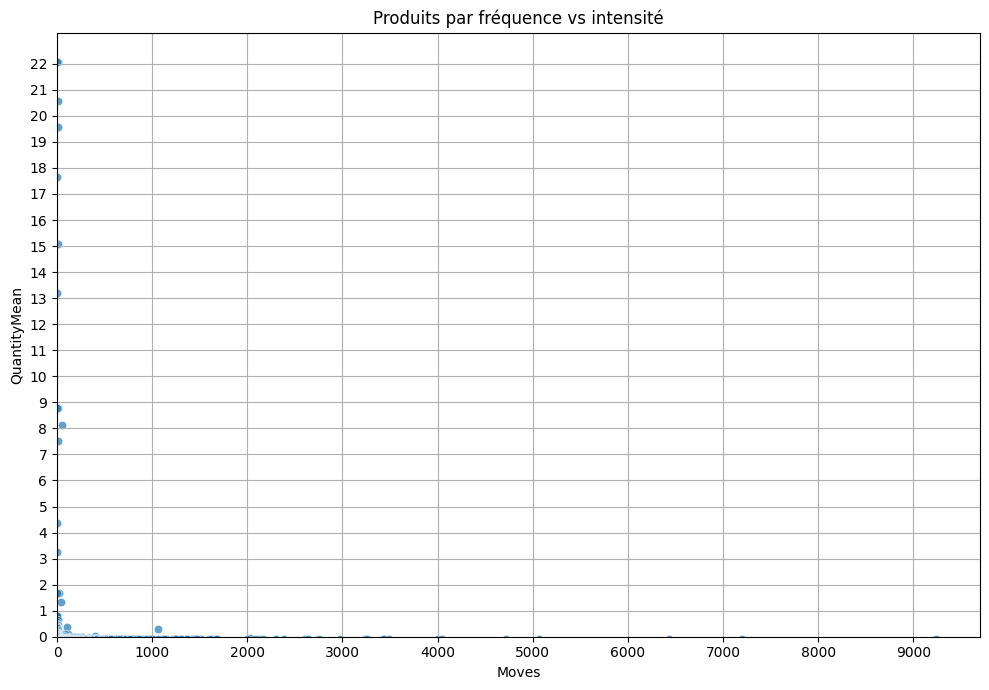

In [498]:
plt.figure(figsize=(10, 7))
ax = sns.scatterplot(
    data=s_2,
    x='Moves',
    y='QuantityMean',
    sizes=(20, 200),
    alpha=0.7
)
xmax, ymax = ax.get_xlim(), ax.get_ylim()
#print(xmax[1], ymax[1])
plt.title("Produits par fréquence vs intensité")
plt.xlabel("Moves")
plt.ylabel("QuantityMean")
plt.xlim(0, xmax[1])
plt.ylim(0, ymax[1])
plt.xticks(range(0, int(xmax[1]), 1000))
plt.yticks(range(0, int(ymax[1]), 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [499]:
s_3 = s_2[(s_2['QuantityMean']<10) & (s_2['Moves']> 1000)].copy()
s_3.head(10)

,ProdId,Moves,QuantityMean
35,5054,1064,0.292946
473,2153,2028,-0.054269
972,1862,4720,-0.075269
1041,1863,3423,-0.076151
1120,6080,1151,-0.076827
1320,5449,1239,-0.078481
1568,1837,1110,-0.079794
1746,4180,1144,-0.080509
1792,4342,9238,-0.080618
1814,3006,1270,-0.080685


In [500]:
s_3.describe()

,ProdId,Moves,QuantityMean
count,58.000000,58.000000,58.000000
mean,2849.224138,2248.827586,-0.074752
std,1797.881463,1618.617735,0.049285
min,171.000000,1001.000000,-0.082917
25%,1432.750000,1252.000000,-0.082537
50%,2845.000000,1611.500000,-0.082192
75%,4214.250000,2631.250000,-0.081276
max,6382.000000,9238.000000,0.292946


<Axes: xlabel='Moves', ylabel='QuantityMean'>

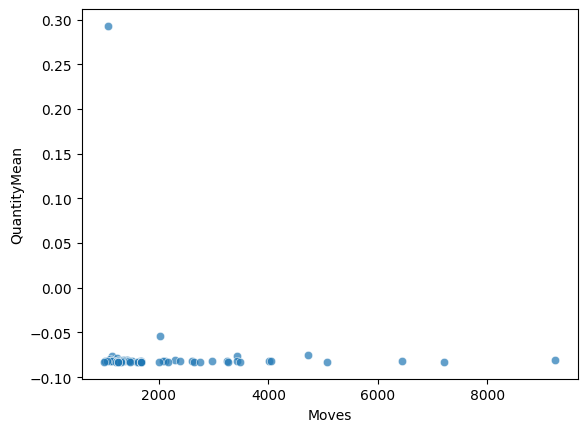

In [501]:
sns.scatterplot(
    data=s_3,
    x='Moves',
    y='QuantityMean',
    sizes=(20, 200),
    alpha=0.7
)

**3.2. Définir le seuil de surstock**

In [502]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='Quantity', data=s_1)
# figure size
plt.xticks(ticks=range(0, int(s_1['Quantity'].max()) + 1, 10)) 
plt.show()

ValueError: Could not interpret value `Quantity` for `x`. An entry with this name does not appear in `data`.

<Figure size 1500x800 with 0 Axes>

D'après ce boxplot, on peut distinguer les produits qui ont des quantités de surstock moyens supérieur à 30.

Donc 30 peut être choisie comme seuil de surstock qui sera utilisé pour la critère de sélection des produits à étudier pour la série chronologique.

In [ ]:
# Mise en place du critère de sélection
seuil = 30
s_130 = s_1[s_1['Quantity'] > seuil]
print(s_130.shape[0])

s_130

13


,ProdId,Quantity
0,6222,250.000000
1,5382,250.000000
2,6214,232.916667
3,5524,221.571429
4,5559,200.000000
5,5925,171.000000
6,6473,150.000000
7,6213,100.000000
8,5523,100.000000
9,5485,92.830189


**3.3. s_2 des produits au delà du seuil de surstock**

In [ ]:
# s_2 des produits dans une nouvelles dataframe
df2 = df[df['ProdId'].isin(s_130['ProdId'])]

# Filtrer les colonnes pertinentes pour l'analyse
df2 = df2[['TransactionDate', 'ProdId', 'CurrentStock']]
df2.head()

,TransactionDate,ProdId,CurrentStock
64975,2020-02-28 15:45:04.770,5382,250.0
67652,2020-03-06 07:07:17.907,5382,0.0
107270,2020-05-15 16:37:17.930,5485,100.0
119123,2020-06-10 14:40:26.780,5523,100.0
119124,2020-06-10 14:40:26.780,5524,100.0


**3.4. Normalisation de la nouvelle dataframe pour la série chronologique**

In [ ]:
# Vérification des valeures manquantes
df2.isnull().sum()

TransactionDate    0
ProdId             0
CurrentStock       0
dtype: int64

In [ ]:
df2['TransactionDate'].dtypes

dtype('O')

In [ ]:
# Convertir la colonne 'TransactionDate' en datetime
df2['TransactionDate'] = pd.to_datetime(df2['TransactionDate'])
df2['TransactionDate'].dtypes

dtype('<M8[ns]')

In [ ]:
# Transfromer la colonne 'TransactionDate' de df2 en index
df2.set_index('TransactionDate', inplace=True)
df2.sort_index(inplace=True, ascending=True)

In [ ]:
df2.describe()

,ProdId,CurrentStock
count,113.000000,113.000000
mean,5808.008850,1547.008850
std,436.695761,1328.038601
min,5382.000000,0.000000
25%,5485.000000,500.000000
50%,5523.000000,1160.000000
75%,6214.000000,2400.000000
max,7628.000000,4920.000000


In [ ]:
df2.head(10)

,ProdId,CurrentStock
TransactionDate,,
2020-02-28 15:45:04.770,5382,250.0
2020-03-06 07:07:17.907,5382,0.0
2020-05-15 16:37:17.930,5485,100.0
2020-06-10 14:40:26.780,5523,100.0
2020-06-10 14:40:26.780,5524,100.0
2020-06-10 17:26:17.290,5485,300.0
2020-06-17 17:00:49.187,5523,250.0
2020-06-24 15:15:39.537,5485,440.0
2020-07-02 15:34:35.213,5559,200.0


In [ ]:
df2.index.min(), df2.index.max()

(Timestamp('2020-02-28 15:45:04.770000'),
 Timestamp('2025-01-23 08:06:21.030000'))

In [ ]:
# Création de la série chronologique
#ts = df2.pivot_table(index='TransactionDate', columns='ProdId', values='CurrentStock', aggfunc='sum')
#ts.head()

### 4. s_2 des produits succeptibles de surstock selon les QUANTITES PERIMES 

### 5. Exportation en CSV